In [102]:
import pyterrier as pt

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

import re
import string

if not pt.started():
  pt.init()

In [3]:
dataset = pt.datasets.get_dataset("vaswani")

In [4]:
topics = dataset.get_topics()
topics

,qid,query
0,1,measurement of dielectric constant of liquids ...
1,2,mathematical analysis and design details of wa...
2,3,use of digital computers in the design of band...
3,4,systems of data coding for information transfer
4,5,use of programs in engineering testing of comp...
...,...,...
88,89,tunnel diode construction and its electrical c...
89,90,electronic density of states at the surface of...
90,91,resistivity of metallic thin films related to ...
91,92,the phenomenon of radiation caused by charged ...


In [5]:
with open(dataset.get_corpus()[0], "r") as f:
    content = f.read()

docs = re.findall(r'<DOC>\s*<DOCNO>(\d+)</DOCNO>\s*(.*?)\s*</DOC>', content, flags=re.DOTALL)

df = pd.DataFrame(docs, columns=["docno", "text"])
df["docno"] = df["docno"].astype(int)

df.head()

,docno,text
0,1,compact memories have flexible capacities a d...
1,2,an electronic analogue computer for solving sy...
2,3,electronic coordinate transformer circuit det...
3,4,the british computer society report of a conf...
4,5,millimicrosecond digital computer logic a sys...


In [6]:
df.shape

(11429, 2)

In [111]:
Nds = df["text"].map(lambda t: re.sub('[' + re.escape(string.punctuation) + ']', ' ', t).split(" ")).map(lambda l : list(filter(("").__ne__, l))).map(len)
Nds

0        21
1        23
2        39
3        11
4        51
         ..
11424    16
11425    34
11426    35
11427    12
11428    32
Name: text, Length: 11429, dtype: int64

In [8]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=4, ngram_range=(1,1), max_features=30)
vectors = vectorizer.fit_transform(df["text"])

In [141]:
def query_likelihood_retrieval(vectorizer, p_vectors, query, collection=False):
    
    if type(p_vectors) != np.ndarray:
        p_vectors = p_vectors.toarray()
    
    query_array = vectorizer.transform([query]).toarray()    
    query_array = (query_array != 0).reshape(-1)
    
    if not query_array.any():
        if not collection:
            return np.zeros(len(p_vectors))
        
        return 0
    
    if collection:
        p_vectors = np.asarray(p_vectors.sum(axis=0) / p_vectors.sum())
        return p_vectors[query_array].prod()
        
    return np.asarray(p_vectors[:, query_array].prod(axis=1)).reshape(-1)

In [146]:
query = topics["query"][0]
P_Q_D_ql = query_likelihood_retrieval(vectorizer, vectors, query)
P_Q_C_ql = query_likelihood_retrieval(vectorizer, vectors, query, collection=True)

In [147]:
P_Q_C_ql

0.0005380887937979582

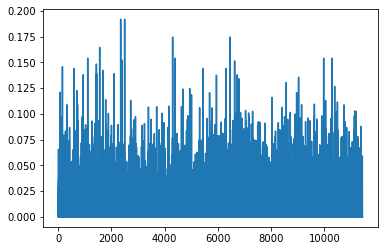

(11429,)

In [148]:
plt.plot(P_Q_D_ql)
plt.show()

P_Q_D_ql.shape

In [162]:
def cluster_based_retrieval(vectorizer, p_vectors, query, doc_clusters, Nds, mu=1000):
    
    n_docs = p_vectors.shape[0]
    P_w_D = np.zeros(n_docs)
    
    ql_doc = query_likelihood_retrieval(vectorizer, p_vectors, query)
    
    clusters = np.unique(doc_clusters)
    ql_cluster = dict()
    for cl in clusters:
        vectors_cluster = p_vectors[doc_clusters == cl]
        ql_cluster[cl] = query_likelihood_retrieval(vectorizer, vectors_cluster, query, collection=True)

    for d in range(n_docs):
        Nd = Nds[d]
        P_w_D[d] = (Nd / (Nd + mu)) *  ql_doc[d] + (1 - (Nd / (Nd + mu))) * ql_cluster[doc_clusters[d]]
    
    return P_w_D

In [150]:
k_means = KMeans(n_clusters=len(topics), verbose=False, random_state=0)

In [151]:
k_means.fit(vectors)
clusters = k_means.labels_

In [152]:
clusters

array([92, 40, 77, ..., 23, 50,  4], dtype=int32)

In [166]:
query = topics["query"][0]
P_Q_D_cluster = cluster_based_retrieval(vectorizer, vectors, query, clusters, Nds)

In [167]:
P_Q_D_cluster

array([0.00023341, 0.00025318, 0.00058655, ..., 0.00011134, 0.00100192,
       0.00032894])

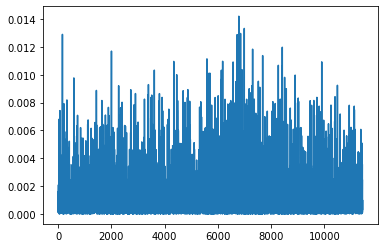

(11429,)

In [168]:
plt.plot(P_Q_D_cluster)
plt.show()

P_Q_D_cluster.shape

In [214]:
def init_params(n_docs, n_topics, vocab_len):
    psi = np.zeros((n_topics, vocab_len))
    theta = np.zeros((n_docs, n_topics))
    return psi, theta

def sample_topic(doc_id, word_id, psi, theta, alpha, beta):
    
    n_topics, n_words = psi.shape
    


    topic_probs = (psi[:, word_id] + beta) / (psi.sum(axis=1) + beta * n_words)
    doc_probs = (theta[doc_id, :] + alpha) / (theta.sum(axis=1)[doc_id] + alpha * n_topics)
    
    p_choice = topic_probs * doc_probs
    p_choice /= p_choice.sum()

    new_topic = np.random.choice(np.arange(n_topics), p=p_choice)
    
    psi[new_topic, word_id] += 1
    theta[doc_id, new_topic] += 1
    
def gibbs_sampling(docs, n_topics, n_iterations, num_chains, alpha=False, beta=0.01):
    n_docs, vocab_len = docs.shape
    
    if alpha == False:
        alpha = 50 / n_topics

    psi_markov = np.zeros((n_topics, vocab_len))
    theta_markov = np.zeros((n_docs, n_topics))

    for chain in range(num_chains):
        
        psi, theta = init_params(n_docs, n_topics, vocab_len)
        
        for iteration in range(n_iterations):
            for doc_id, doc in enumerate(docs):
                for word_id in np.where(doc != 0)[0]:
                    sample_topic(doc_id, word_id, psi, theta, alpha, beta)
                    
        psi_markov += psi
        theta_markov += theta
    
    psi_markov /= num_chains
    theta_markov /= num_chains

    return psi_markov, theta_markov

In [231]:
psi, tetha = gibbs_sampling(vectors.toarray(), len(topics), 1, 2)